In [1]:
from strace_miner.core.strace_analyzer import StraceAnalyzer
from strace_miner.core.preprocessor import Preprocessor
from strace_miner.core.strace_line_reader import StraceLineReader

Sample log

In [20]:
%%bash
#strace -f -tt -T -r -o logs/mmarrays.st python src/mmarrays.py 100000
strace -f -tt -T -r -o logs/multi_threaded.st python src/multi_threaded.py

In [5]:
#LOG_FILE =  "logs/mmarrays.st"
LOG_FILE =  "logs/multi_threaded.st"

In [6]:
st_log_ = LOG_FILE

with open(st_log_,'r') as f:
    for line in f:
        if '<unfinished' in line:
            print(line.strip())
        elif 'resumed>)' in line:
            print(line.strip())

77423 16:56:40.424017 (+     0.000307) mmap(NULL, 8392704, PROT_NONE, MAP_PRIVATE|MAP_ANONYMOUS|MAP_STACK, -1, 0 <unfinished ...>
77424 16:56:40.424041 (+     0.000018) set_robust_list(0x7f0bf06989e0, 24 <unfinished ...>
77423 16:56:40.424057 (+     0.000015) <... mmap resumed>) = 0x7f0bef697000 <0.000026>
77424 16:56:40.424190 (+     0.000082) <... set_robust_list resumed>) = 0 <0.000143>
77423 16:56:40.424209 (+     0.000016) clone(child_stack=0x7f0befe96fb0, flags=CLONE_VM|CLONE_FS|CLONE_FILES|CLONE_SIGHAND|CLONE_THREAD|CLONE_SYSVSEM|CLONE_SETTLS|CLONE_PARENT_SETTID|CLONE_CHILD_CLEARTID <unfinished ...>
77425 16:56:40.424493 (+     0.000032) set_robust_list(0x7f0befe979e0, 24 <unfinished ...>
77423 16:56:40.424511 (+     0.000018) mmap(NULL, 8392704, PROT_NONE, MAP_PRIVATE|MAP_ANONYMOUS|MAP_STACK, -1, 0 <unfinished ...>
77424 16:56:40.424529 (+     0.000017) mbind(0x7f0be7697000, 134217728, MPOL_PREFERRED, NULL, 0, 0 <unfinished ...>
77423 16:56:40.424548 (+     0.000018) <... mmap 

In [15]:
import re

inp_str = "75695 16:45:18.047384 (+     0.000250) write(9, \"\0\0\0\0\0\0\0\0\1\0\0\0\0\0\0\0\2\0\0\0\0\0\0\0\3\0\0\0\0\0\0\0\"..., 1998848 <unfinished ...>"
pattern = r'write\((.*?)\<[^<]*$'
slr_ = StraceLineReader()
slr_.set_line(inp_str)
slr_.match_pattern(pattern)

'9, "\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00"..., 1998848 '

In [33]:
inp_str = '77423 16:56:40.453123 (+     0.000020) <... read resumed>"", 1) = 0 <0.000224>'
int(inp_str.split()[-4][:-1])

1

In [14]:
%%writefile ../strace_miner/views/v2/io_line_reader.py

from ...core.strace_line_reader import StraceLineReader

class IOLineReaderV2(StraceLineReader):
    def __init__(self):
        super().__init__()


    def get_bytes(self,call,unfinished,resumed):
        
        if call=='write':
            if unfinished:
                pattern = r'{}\((.*?)\<[^<]*$'.format(call)
                ret = self.match_pattern(pattern).split(',')
                bytes = int(ret[-1])
            elif resumed:
                return None
            else:
                pattern = r'{}\((.*?)\)[^)]*$'.format(call)
                ret = self.match_pattern(pattern).split(',')
                bytes = int(ret[-1])

        if call=='read':
            if resumed:
                bytes = int(self.line.split()[-4][:-1])
            elif unfinished:
                return None
            else:
                pattern = r'{}\((.*?)\)[^)]*$'.format(call)
                ret = self.match_pattern(pattern).split(',')
                bytes = int(ret[-1])

        
        if bytes == 0:
            val = '0'
        elif bytes < 1024*4:
            val = '[<4KB]'
        elif bytes < 1024*1024*4:
            val = '[<4MB]'
        else:
            val = '[>4MB]'

        return val
       

    def parse_call_attrs(self,call,unfinished,resumed,error=False):
        if error or call not in ['read','write']:
            if not unfinished:
                return ['0',]
            else:
                return []
            
        val = self.get_bytes(call,unfinished,resumed)
        return [val,]

Overwriting ../strace_miner/views/v2/io_line_reader.py


In [3]:
lr = IOLineReaderV2()

In [7]:
with open(st_log_,'r') as f:
    for line in f:
        #print(line)
        ret = lr.process_line(line)
        if ret:
            if len(ret)>5:
                print(ret)

In [8]:
%%writefile ../strace_miner/views/v2/io_miner_v2.py
from ...core.strace_analyzer import StraceAnalyzer
from ...core.preprocessor import Preprocessor
from .io_line_reader import IOLineReaderV2

import os
import pm4py
import pandas as pd


class IOMinerV2(StraceAnalyzer):
    def __init__(self,st_log_paths,io_calls):
        super().__init__(st_log_paths)
        self.io_calls = io_calls
        self.slr = IOLineReaderV2()
    
    def preprocess(self, reuse=False):
        for st_path in self.st_log_paths: 
              st = Preprocessor(st_path,self.io_calls,self.slr,'IO')
              st.extra = ['bytes',]
              case_id = os.path.basename(st_path).split('.st')[0]
              if not reuse:
                st.prepare_csv_log()
            
              self.st_logs[case_id] = st
    
    def prepare_summaries_and_event_log(self):
         df_all = []
         for case_id,st in self.st_logs.items():
              df = st.get_df_from_csv()
              summary, df = st.process(df)
              self.summaries[case_id] = summary
              df['case'] = case_id
              df['concept'] = df['call'] + '_' + df['bytes'].astype(str)
              df = pm4py.format_dataframe(df,case_id='case',activity_key='concept',timestamp_key='time')
              df_all.append(df)

         self.el = pm4py.convert_to_event_log(pd.concat(df_all,ignore_index=True))


    def prepare_dfg(self):
         self.dfg,self.dfg_im,self.dfg_fm = pm4py.discover_dfg(self.el)

    def view_dfg(self):
         if self.dfg:
              return pm4py.view_dfg(self.dfg,self.dfg_im,self.dfg_fm)

In [9]:
LOG_FILE =  "logs/mmarrays.st"
#LOG_FILE =  "logs/multi_threaded.st"

io_calls = ['read','write']
sta = IOMinerV2([LOG_FILE,],io_calls)

In [10]:
sta.preprocess()

CSV log path: logs/mmarrays.csv


In [11]:
sta.st_logs[list(sta.st_logs.keys())[0]].get_df_from_csv()

,pid,call,time,duration,bytes
0,71009,execve,16:17:51.076481,0.000245,0
1,71009,brk,16:17:51.076985,0.000080,0
2,71009,readlink,16:17:51.077227,0.000104,0
3,71009,access,16:17:51.077435,0.000065,0
4,71009,openat,16:17:51.077701,0.000104,0
...,...,...,...,...,...
16523,71009,munmap,16:17:54.041258,0.000069,0
16524,71009,munmap,16:17:54.041486,0.000049,0
16525,71009,munmap,16:17:54.041627,0.000041,0
16526,71009,exit_group,16:17:54.041964,-2.000000,0


In [12]:
sta.prepare_summaries_and_event_log()
sta.prepare_dfg()

/home/vscode/.local/lib/python3.12/site-packages/pm4py/utils.py:538: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


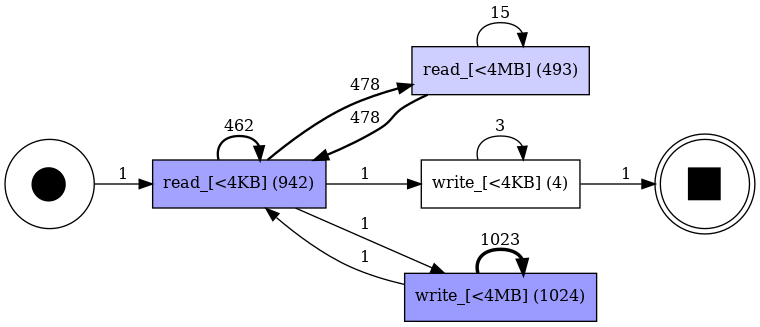

In [13]:
sta.view_dfg()